# Get SRTM data through a BMI

This notebook describes how to download Shuttle Radar Topography Mission (SRTM) elevation data
using a [Basic Model Interface](https://bmi.readthedocs.io/) (BMI) through the `BmiTopography` class included in the `bmi-topography` package.

## Setup

To ensure all dependencies are met, set up a conda environment using the environment file found in the root directory of this repository:
```
conda env create --file=environment.yml
```

Then install the `bmi-topography` package:
```
make install
```

Import a pair of libraries for later use:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fetch and load data

Import the `BmiTopography` class from the newly installed `bmi-topography` package:

In [2]:
from bmi_topography import BmiTopography

Create an instance of this class.

In [3]:
m = BmiTopography()

Calling `help` on the instance displays all the BMI methods that are available.

In [4]:
help(m)

Help on BmiTopography in module bmi_topography.bmi object:

class BmiTopography(bmipy.bmi.Bmi)
 |  BmiTopography() -> None
 |  
 |  BMI-mediated access to NASA SRTM land elevation data.
 |  
 |  Method resolution order:
 |      BmiTopography
 |      bmipy.bmi.Bmi
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  finalize(self) -> None
 |      Perform tear-down tasks for the model.
 |      
 |      Perform all tasks that take place after exiting the model's time
 |      loop. This typically includes deallocating memory, closing files and
 |      printing reports.
 |  
 |  get_component_name(self) -> str
 |      Name of the component.
 |      
 |      Returns
 |      -------
 |      str
 |          The name of the component.
 |  
 |  get_current_time(self) -> float
 |      Current time of the model.
 |      
 |      Returns
 |      -------
 |      float
 | 

The first step in using a BMI is calling the `initialize` method.
This method requires a configuration file that provides initial values for the `Topography` library wrapped by the BMI.

A sample configuration file is provided in the current directory.

In [5]:
ls

bmi-topography.ipynb  config.yaml           topography.ipynb
bmi-topography_ex.sh  bmi-topography_ex.py


In [6]:
cat config.yaml

bmi-topography:
  dem_type: SRTMGL3
  south: 36.738884
  north: 38.091337
  west: -120.168457
  east: -118.465576
  output_format: GTiff
  cache_dir: "~/.bmi_topography"


Call `initialize` with the sample configuration file.

In [7]:
m.initialize("config.yaml")

This step may take a moment, as the `Topography` library fetches and downloads the data from the internet.

Once the step completes, check the contents of your cache directory:

In [8]:
ls ~/.bmi_topography

SRTMGL3_36.738884_-120.168457_38.091337_-118.465576.tif


## Access data through the BMI

Now that we've fetched the data, let's access it through the BMI.
This will take a few steps.
It may seem cumbersome at first, but there's payoff at the end.

Start by displying the name of the one variable exposed through the BMI.

In [9]:
m.get_output_var_names()

('land_surface__elevation',)

The (long) name for the variable representing elevation is an instance of a [CSDMS Standard Name](https://csdms.colorado.edu/wiki/CSDMS_Standard_Names).
Standard Names are intended to be unambiguous; the tradeoff is that they tend to be long.

Find the data type of the elevation data.

In [10]:
dtype = m.get_var_type("land_surface__elevation")
dtype

'int16'

Within the BMI, functions that describe the grids that variables are defined on take an index instead of a variable name.

Get the grid index for the elevation variable.

In [11]:
grid = m.get_var_grid("land_surface__elevation")
grid

0

Then find the total size of the elevation data.

In [12]:
size = m.get_grid_size(grid)
size

3315789

Next, get the elevation values.

Two notes, however:

* As a rule, memory should not be allocated within a BMI. This leads to the un-Pythonic way that we get the elevation data--first creating an empty array, then passing it to a BMI function to receive values.
* BMI arrays are flattened. This obviates array ordering issues between languages, but it does make >1D data harder to work with.

Allocate an array for the elevation data.

In [13]:
elevation = np.ndarray(size, dtype)
elevation

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

Get the elevation data.

In [14]:
m.get_value("land_surface__elevation", elevation)

array([1295, 1339, 1380, ..., 3519, 3467, 3423], dtype=int16)

Note that the elevation array is one-dimensional.

In [15]:
elevation.shape

(3315789,)

### Reshape data

Like all BMI arrays, the elevations returned from the BMI `get_value` function are flattened.
Let's restore their original dimensionality.

First, determine the dimensionality of the elevation variable.

In [16]:
rank = m.get_grid_rank(grid)
rank

2

Get the dimensions of the elevation data, first creating an array to store their values.

In [17]:
shape = np.ndarray(rank, dtype=int)
shape

array([1623, 2043])

In [18]:
m.get_grid_shape(grid, shape)

array([1623, 2043])

Reshape the elevation data, creating a new array.

In [19]:
elevation2D = elevation.reshape(shape)

In [20]:
elevation2D.shape

(1623, 2043)

## Visualize

Let's visualize the elevation data as an image.

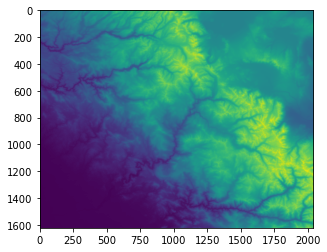

In [21]:
plt.imshow(elevation2D)

## Conclusion

Last, call the BMI `finalize` function.

In [22]:
m.finalize()

This demonstration of the BMI took a lot of code to reproduce a simple result.
So why would anyone want to use the BMI?
The key is that, in this demonstration, only the functions belonging to the BMI were used to access the data.
No knowledge of the calling syntax of the underlying `Topography` class was used.

The lesson is: once you've seen one BMI, you've seen them all!